<a href="https://colab.research.google.com/github/willianncardoso/IBOVESPA/blob/main/PosFIAP_T2_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Previsão de Tendência do IBOVESPA
## Tech Challenge — Fundo de Investimentos

**Objetivo**: Desenvolver um modelo preditivo capaz de prever se o índice IBOVESPA fechará em alta ou baixa no dia seguinte, com base em dados históricos.

- **Período**: 2 anos de dados diários
- **Target**: 1 se o fechamento do dia seguinte for maior, 0 caso contrário
- **Avaliação**: Acurácia no último mês (30 dias)

 Parte 1 – Modelo com variáveis externas (S&P500, Nasdaq, Dólar)

 1. Instalação de bibliotecas

In [6]:
!pip install yfinance
!pip install imbalanced-learn
!pip install xgboost
!pip install seaborn


 2. Upload dos dados do IBOVESPA

In [7]:
# from google.colab import files
# uploaded = files.upload()


 3. Carregamento e tratamento do IBOVESPA

In [8]:
import pandas as pd
import numpy as np

# Carrega CSV
df = pd.read_csv("https://raw.githubusercontent.com/jaqueantunes/IBOVESPA/refs/heads/main/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv")
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

# Ajusta colunas numéricas
def convert_volume(valor):
    if 'B' in valor:
        return float(valor.replace(',', '.').replace('B', '')) * 1_000_000_000
    elif 'M' in valor:
        return float(valor.replace(',', '.').replace('M', '')) * 1_000_000
    else:
        return float(valor.replace(',', '.'))

df['Vol.'] = df['Vol.'].apply(convert_volume)

for col in ['Último', 'Abertura', 'Máxima', 'Mínima']:
    df[col] = df[col].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)

df['Var%'] = df['Var%'].astype(str).str.replace(',', '.').str.replace('%', '').astype(float)
df = df.sort_values('Data').reset_index(drop=True)


In [9]:
print("Data inicial:", df["Data"].min())
print("Data final:", df["Data"].max())

Data inicial: 2023-06-30 00:00:00
Data final: 2025-07-04 00:00:00


In [10]:
# === 3. Features básicas ===
df['Retorno_1d'] = df['Último'].pct_change(1)
df['Retorno_3d'] = df['Último'].pct_change(3)
df['Retorno_5d'] = df['Último'].pct_change(5)
df['Momentum_5d'] = df['Último'] - df['Último'].shift(5)

In [11]:
# === 4. Indicadores técnicos ===
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_macd(series, short=12, long=26, signal=9):
    ema_short = series.ewm(span=short, adjust=False).mean()
    ema_long = series.ewm(span=long, adjust=False).mean()
    macd = ema_short - ema_long
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    return macd, macd_signal

df['RSI_14'] = calculate_rsi(df['Último'])
df['MACD'], df['MACD_signal'] = calculate_macd(df['Último'])
df['MACD_diff'] = df['MACD'] - df['MACD_signal']

In [12]:
# === 5. Lags ===
df['Lag_Ret_1'] = df['Retorno_1d'].shift(1)
df['Lag_Ret_2'] = df['Retorno_1d'].shift(2)
df['Lag_Ret_5'] = df['Retorno_1d'].shift(5)
df['Lag_RSI_1'] = df['RSI_14'].shift(1)

In [13]:
# === 6. Target ===
df['Target'] = (df['Último'].shift(-1) > df['Último']).astype(int)

In [14]:
# === 7. Limpeza final ===
df = df.dropna().reset_index(drop=True)

In [15]:
# === 8. Seleção de features ===
features = [
    'Retorno_1d', 'Retorno_3d', 'Retorno_5d',
    'Momentum_5d',
    'RSI_14', 'MACD_diff',
    'Lag_Ret_1', 'Lag_Ret_2', 'Lag_Ret_5', 'Lag_RSI_1'
]

X = df[features]
y = df['Target']

In [16]:
# === 9. Split temporal ===
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:19:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Acurácia: 0.7
Matriz de Confusão:
 [[13  3]
 [ 6  8]]
Relatório:
               precision    recall  f1-score   support

           0       0.68      0.81      0.74        16
           1       0.73      0.57      0.64        14

    accuracy                           0.70        30
   macro avg       0.71      0.69      0.69        30
weighted avg       0.70      0.70      0.69        30



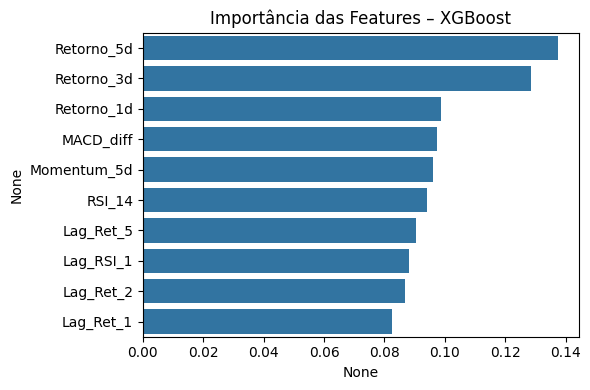

In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# === 10. Modelo ===
model = XGBClassifier(
    max_depth=4,
    n_estimators=200,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# === 11. Avaliação ===
y_pred = model.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("Relatório:\n", classification_report(y_test, y_pred))

# === 12. Importância das variáveis ===
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Importância das Features – XGBoost")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:19:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Acurácia: 0.7333333333333333
Matriz de Confusão:
 [[13  3]
 [ 5  9]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.72      0.81      0.76        16
           1       0.75      0.64      0.69        14

    accuracy                           0.73        30
   macro avg       0.74      0.73      0.73        30
weighted avg       0.74      0.73      0.73        30



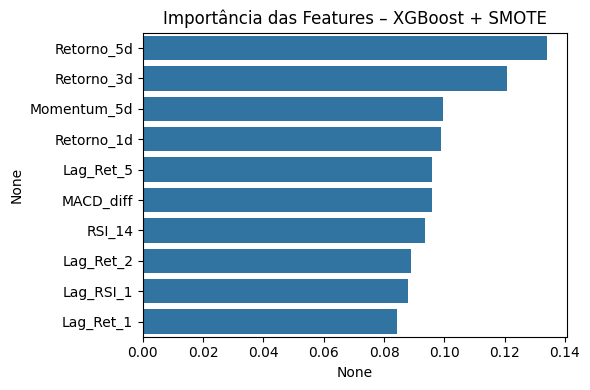

In [18]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# === 7. Aplica SMOTE no treino ===

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# === 8. Treina o modelo ===
model = XGBClassifier(
    max_depth=4,
    n_estimators=200,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train_res, y_train_res)

# === 9. Avaliação ===
y_pred = model.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

# === 10. Importância das features ===
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Importância das Features – XGBoost + SMOTE")
plt.tight_layout()
plt.show()

In [19]:
# Cria DataFrame com previsões
df_resultado = df.iloc[-30:].copy()

# Adiciona as previsões do modelo
df_resultado['Previsao'] = y_pred
df_resultado['Previsao'] = df_resultado['Previsao'].map({1: 'Alta', 0: 'Baixa'})

# Adiciona o valor real do Target (Alta ou Baixa)
df_resultado['Real'] = df_resultado['Target'].map({1: 'Alta', 0: 'Baixa'})

# Verifica se acertou ou errou
df_resultado['Acertou'] = np.where(df_resultado['Previsao'] == df_resultado['Real'], 'Sim', 'Não')

# Seleciona colunas para exibir
tabela_final = df_resultado[['Data', 'Último', 'Previsao', 'Real', 'Acertou']].reset_index(drop=True)

# Exibe a tabela
import pandas as pd
from IPython.display import display
display(tabela_final)


,Data,Último,Previsao,Real,Acertou
0,2025-05-23,137824.0,Alta,Alta,Sim
1,2025-05-26,138136.0,Baixa,Alta,Não
2,2025-05-27,139541.0,Baixa,Baixa,Sim
3,2025-05-28,138888.0,Alta,Baixa,Não
4,2025-05-29,138534.0,Baixa,Baixa,Sim
5,2025-05-30,137027.0,Baixa,Baixa,Sim
6,2025-06-02,136787.0,Alta,Alta,Sim
7,2025-06-03,137546.0,Baixa,Baixa,Sim
8,2025-06-04,137002.0,Baixa,Baixa,Sim
9,2025-06-05,136236.0,Baixa,Baixa,Sim


 4. Inclusão das variáveis externas

In [20]:
import yfinance as yf

tickers = {
    '^GSPC': 'SP500',
    '^IXIC': 'NASDAQ',
    'DX-Y.NYB': 'DOLLAR_INDEX'
}

start_date = df['Data'].min().strftime('%Y-%m-%d')
end_date = df['Data'].max().strftime('%Y-%m-%d')

external = yf.download(list(tickers.keys()), start=start_date, end=end_date)['Close']
external = external.rename(columns={k: v for k, v in tickers.items() if k in external.columns})
external = external.reset_index().rename(columns={'Date': 'Data'})
external['Data'] = pd.to_datetime(external['Data'])

# Junta com o IBOVESPA
df2 = pd.merge(df, external, on='Data', how='left')


/tmp/ipython-input-2122367623.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  external = yf.download(list(tickers.keys()), start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


In [21]:
df2.head(5)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Retorno_1d,Retorno_3d,Retorno_5d,...,MACD_signal,MACD_diff,Lag_Ret_1,Lag_Ret_2,Lag_Ret_5,Lag_RSI_1,Target,DOLLAR_INDEX,SP500,NASDAQ
0,2023-07-21,120217.0,11809.0,120373.0,118086.0,11180000.0,1.81,0.018072,0.020163,0.021289,...,17.625628,87.201743,0.004517,-0.002452,-0.013022,49.984076,1,101.070000,4536.339844,14032.809570
1,2023-07-24,121342.0,12022.0,121772.0,120099.0,10490000.0,0.94,0.009358,0.032241,0.026417,...,80.195439,250.279244,0.018072,0.004517,0.004316,52.075069,1,101.349998,4554.640137,14058.870117
2,2023-07-25,122008.0,121344.0,12301.0,121344.0,11430000.0,0.55,0.005489,0.033239,0.035361,...,175.481551,381.144448,0.009358,0.018072,-0.003197,58.308888,0,101.349998,4567.459961,14144.559570
3,2023-07-26,12256.0,122003.0,122747.0,12137.0,9990000.0,0.45,-0.899548,-0.898051,-0.895740,...,-1465.150467,-6562.528070,0.005489,0.009358,-0.002452,58.890737,0,100.889999,4566.750000,14127.280273
4,2023-07-27,11999.0,12256.0,122599.0,119825.0,10680000.0,-2.10,-0.020969,-0.901114,-0.898385,...,-4108.578607,-10573.712560,-0.899548,0.005489,0.004517,6.705199,1,101.769997,4537.410156,14050.110352


 5. Criação das variáveis técnicas

In [22]:


# Retornos externos
for col in ['SP500', 'NASDAQ', 'DOLLAR_INDEX']:
    df2[f'{col}_ret_1d'] = df2[col].pct_change(1)
    df2[f'{col}_ret_3d'] = df2[col].pct_change(3)




/tmp/ipython-input-2425858281.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df2[f'{col}_ret_1d'] = df2[col].pct_change(1)
/tmp/ipython-input-2425858281.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df2[f'{col}_ret_3d'] = df2[col].pct_change(3)
/tmp/ipython-input-2425858281.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df2[f'{col}_ret_1d'] = df2[col].pct_change(1)
/tmp/ipython-input-

In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define as features
features = [
    'Retorno_1d', 'Retorno_3d', 'Retorno_5d', 'Momentum_5d',
    'RSI_14', 'MACD_diff', 'Lag_Ret_1', 'Lag_Ret_2', 'Lag_Ret_5', 'Lag_RSI_1',
    'SP500_ret_1d', 'SP500_ret_3d', 'NASDAQ_ret_1d', 'NASDAQ_ret_3d',
    'DOLLAR_INDEX_ret_1d', 'DOLLAR_INDEX_ret_3d'
]

# Define X e y
X = df2[features]
y = df2['Target']

# Separa treino e teste
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

# Treinamento
model = XGBClassifier(
    max_depth=4,
    n_estimators=200,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Avaliação
print("Modelo com variaveis externas")
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:19:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Modelo com variaveis externas
Acurácia: 0.6333333333333333
Matriz de Confusão:
 [[11  5]
 [ 6  8]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.65      0.69      0.67        16
           1       0.62      0.57      0.59        14

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30

